# 2-2_CNN_Advanced

### LeNet
LeNet is a convolutional neural network structure proposed by Yann LeCun et al. in 1989. In general, LeNet refers to lenet-5 and is a simple convolutional neural network. Convolutional neural networks are a kind of feed-forward neural network whose artificial neurons can respond to a part of the surrounding cells in the coverage range and perform well in large-scale image processing.
* paper: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

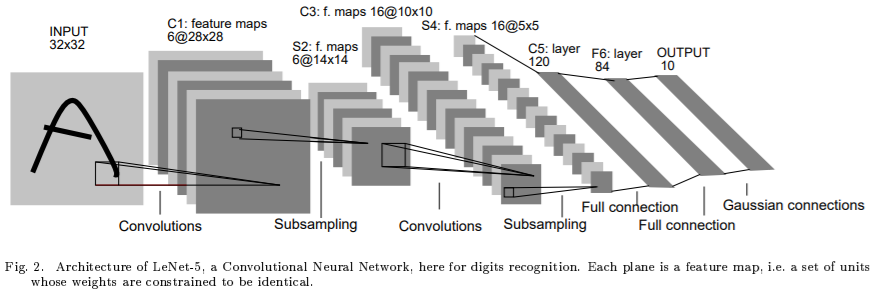

Description
* input: 32x32 pixel image / database는 28x28인데, 이를 center로 모아주기 위하여 다소 크게 만듬
* C1: conv2d(1, 6, kernel=5)과 동일
* S2: avg_pool2d(kernel=2) + 각 픽셀별 add+bias + sigmoid
* C3: conv2d(6, 16, kernel=5)과 동일
* S4: S2와 거의 동일
* C5: conv2d(16, 120, kernel=5)
* F6: Linear(120, 84)
* activation: hyperbolic tangent function


### AlexNet

AlexNet competed in the [ImageNet Large Scale Visual Recognition Challenge on September 30, 2012](http://www.image-net.org/challenges/LSVRC/2012/results.html). AlexNet is considered one of the most influential papers published in computer vision, having spurred many more papers published employing CNNs and GPUs to accelerate deep learning. As of 2020, the [AlexNet paper](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=ImageNet+Classification+with+Deep+Convolutional+Neural+Networks&btnG=) has been cited over 70,000 times according to Google Scholar.

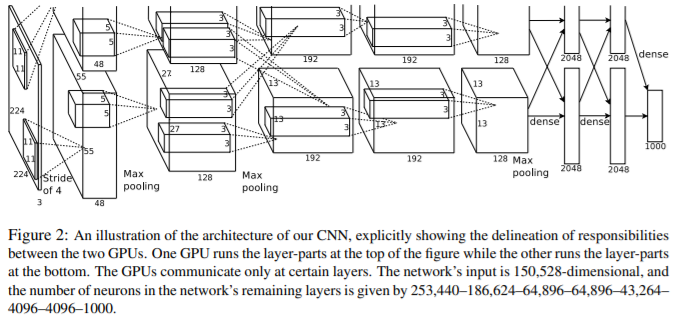

description
* ILSVRC 12 우승 -> 실제로 확인해볼 수 있음
* 큰 족적을 남김
* paper citation 70k 이상
* paer 확인해보면
* 구조
  * relu
  * multi GPU
  * local response normalization: 서로 다른 channel에서 동일 위치에 대하여 normalize
  * overlapping pooling = kernel이 1보다 크고 and stride보다 kernel이 큼
  * groupped convolution for 2, 4, 5
  * local response normalization: 1,2 (무시) -> pytorch 검색 됨
  * max pooling: 1, 2, 5
  * relu는 모든 conv output
* data augmentation
  * 224x224 patch from 256x256 image -> 2048배 data
  * horizontal reflection
  * test에도 마찬가지로 뽑아서 총 10장 -> average prediction
  * altering RGB intensities
* dropout
  * batch size 128, momentum 0.9, weight decay 0.0005

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm
import time

device = 'cuda'

In [2]:
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print('Calculated means: {}'.format(means))
print('Calculated stds: {}'.format(stds))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


In [3]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=means, std=means),
     transforms.RandomHorizontalFlip(),])
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


cifar10_train = torchvision.datasets.CIFAR10(root='data', train=True, transform=transform_train, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='data', train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class AlexNet(nn.Module):
    def __init__(self, output_dim=10):
        super().__init__()
        
        self.features = nn.Sequential(
            # kernel size, stride, padding are modified
            # 3x32x32
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            # 64x16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64x8x8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            # 192x8x8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 192x4x4
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            # 384x4x4
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # 256x4x4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 256x2x2
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [5]:
train_batch = 100
test_batch = 200
n_epochs = 15
num_workers = 4
lr = 0.01
momentum = 0.9
log_dir = 'log/cifar10/alexnet'

model = AlexNet(output_dim=10)

train_loader = DataLoader(
    cifar10_train, train_batch, sampler=RandomSampler(cifar10_train),
    num_workers=num_workers)
test_loader = DataLoader(
    cifar10_test, test_batch, num_workers=num_workers)
n_minibatches = len(train_loader)

# it combines softmax with negative log likelihood loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Move model to gpu if possible
model = model.to(device)

training_start_time = time.time()
writer = SummaryWriter(log_dir)
step = 0

for epoch in range(1, n_epochs+1): # loop over the dataset multiple times
    
    write_period = n_minibatches // 100
    start_time = time.time()
    train_loss = 0
    
    for x, y in tqdm(train_loader):
        # Move tensors to correct device
        x, y = x.to(device), y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach()
        
        step += 1
        # Summary
        if step % write_period == 0:
            writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    total, correct = 0, 0
    test_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Don't compute gradient during evaluation
        with torch.no_grad():
            pred = model(x)

        test_loss += criterion(pred, y) * x.shape[0]

        total += x.shape[0]
        correct += (pred.max(dim=1)[1] == y).sum()

    test_loss /= total
    accuracy = correct / total

    writer.add_scalar('loss/test', test_loss, step)
    writer.add_scalar('accuracy', accuracy, step)
    
    print("Epoch {} in {:.2f}s, train_loss={:.2f}, test_loss={:.2f}, test_accuracy={:.2f}".
          format(epoch, time.time() - start_time, train_loss / n_minibatches,
                test_loss, accuracy))

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 in 8.55s, train_loss=2.29, test_loss=2.15, test_accuracy=0.18


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 in 4.26s, train_loss=1.88, test_loss=1.82, test_accuracy=0.33


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 in 4.26s, train_loss=1.53, test_loss=1.60, test_accuracy=0.40


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 in 4.26s, train_loss=1.31, test_loss=1.30, test_accuracy=0.53


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 in 4.27s, train_loss=1.12, test_loss=1.10, test_accuracy=0.60


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6 in 4.27s, train_loss=1.00, test_loss=1.00, test_accuracy=0.64


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7 in 4.30s, train_loss=0.89, test_loss=0.90, test_accuracy=0.68


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8 in 4.29s, train_loss=0.81, test_loss=0.91, test_accuracy=0.68


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9 in 4.24s, train_loss=0.74, test_loss=0.84, test_accuracy=0.71


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10 in 4.29s, train_loss=0.67, test_loss=0.85, test_accuracy=0.71


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11 in 4.28s, train_loss=0.62, test_loss=0.77, test_accuracy=0.74


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12 in 4.29s, train_loss=0.57, test_loss=0.75, test_accuracy=0.74


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13 in 4.26s, train_loss=0.51, test_loss=0.75, test_accuracy=0.75


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14 in 4.25s, train_loss=0.48, test_loss=0.73, test_accuracy=0.76


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15 in 4.27s, train_loss=0.43, test_loss=0.73, test_accuracy=0.76


### Practice: VGG

Implementing VGG variant
* https://arxiv.org/abs/1409.1556

|VGG variant|
| --- |
| input (32 x 32 RGB image) |
||
| conv (kernel 3, channel 16) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 32) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 64) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 128) |
| conv (kernel 3, channel 256) |
||
| fc (1024) |
| fc (1024) |
| soft-max |

* 2014 ILSVRC 확인 가능
* input: 224x224 RGB image
* conv 3x3 or 1x1 kernel, 1 stride, 1 padding
* maxpooling with 2x2 window, 2 stride


In [6]:
class VGG(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            # 3x32x32
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 16x16x16
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 32x8x8
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 64x4x4
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [7]:
train_batch = 100
test_batch = 200
n_epochs = 15
num_workers = 4
lr = 0.01
momentum = 0.9
log_dir = 'log/cifar10/vgg'

model = VGG(output_dim=10)

train_loader = DataLoader(
    cifar10_train, train_batch, sampler=RandomSampler(cifar10_train),
    num_workers=num_workers)
test_loader = DataLoader(
    cifar10_test, test_batch, num_workers=num_workers)
n_minibatches = len(train_loader)

# it combines softmax with negative log likelihood loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Move model to gpu if possible
model = model.to(device)

training_start_time = time.time()
writer = SummaryWriter(log_dir)
step = 0

for epoch in range(1, n_epochs+1): # loop over the dataset multiple times
    
    write_period = n_minibatches // 100
    start_time = time.time()
    train_loss = 0
    
    for x, y in tqdm(train_loader):
        # Move tensors to correct device
        x, y = x.to(device), y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach()
        
        step += 1
        # Summary
        if step % write_period == 0:
            writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    total, correct = 0, 0
    test_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Don't compute gradient during evaluation
        with torch.no_grad():
            pred = model(x)

        test_loss += criterion(pred, y) * x.shape[0]

        total += x.shape[0]
        correct += (pred.max(dim=1)[1] == y).sum()

    test_loss /= total
    accuracy = correct / total

    writer.add_scalar('loss/test', test_loss, step)
    writer.add_scalar('accuracy', accuracy, step)
    
    print("Epoch {} in {:.2f}s, train_loss={:.2f}, test_loss={:.2f}, test_accuracy={:.2f}".
          format(epoch, time.time() - start_time, train_loss / n_minibatches,
                test_loss, accuracy))

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 in 3.27s, train_loss=2.30, test_loss=2.27, test_accuracy=0.19


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 in 3.23s, train_loss=1.81, test_loss=1.59, test_accuracy=0.41


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 in 3.17s, train_loss=1.46, test_loss=1.39, test_accuracy=0.49


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 in 3.19s, train_loss=1.24, test_loss=1.22, test_accuracy=0.56


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 in 3.23s, train_loss=1.06, test_loss=1.09, test_accuracy=0.62


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6 in 3.19s, train_loss=0.92, test_loss=0.94, test_accuracy=0.67


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7 in 3.19s, train_loss=0.83, test_loss=0.86, test_accuracy=0.70


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8 in 3.21s, train_loss=0.75, test_loss=0.85, test_accuracy=0.70


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9 in 3.22s, train_loss=0.69, test_loss=0.83, test_accuracy=0.72


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10 in 3.17s, train_loss=0.63, test_loss=0.73, test_accuracy=0.75


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11 in 3.17s, train_loss=0.58, test_loss=0.72, test_accuracy=0.75


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12 in 3.07s, train_loss=0.54, test_loss=0.72, test_accuracy=0.76


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13 in 3.04s, train_loss=0.50, test_loss=0.73, test_accuracy=0.75


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14 in 3.26s, train_loss=0.45, test_loss=0.75, test_accuracy=0.75


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15 in 3.15s, train_loss=0.41, test_loss=0.72, test_accuracy=0.77


### References
* https://pytorch.org/docs/stable/torchvision/models.html
* https://paperswithcode.com/sota/image-classification-on-imagenet